In [2]:
from support_functions import *
import numpy as np
from glob import glob
from pydicom import dcmread
import matplotlib.pyplot as plt
import joblib
import tqdm

# Inlezen en verwerken scans
In dit notebook wordt een eerste blik geworpen op de aanwezige scans. Deze zullen dan naar 2 dimensies worden omgezet en genormaliseerd.

## Scans naar 2D omzetten
In dit gedeelte worden de verschillende manieren waarop dit mogelijk is bekeken, en een beste manier hiervoor gekozen.

In [3]:
scan1 = read_dicom_slices('scans/CAC-Scans-Anonymous/1')
scan1

array([[[-66, -66, -66, ..., -66, -66, -66],
        [-66, -66, -66, ..., -66, -66, -66],
        [-66, -66, -66, ..., -66, -66, -66],
        ...,
        [-66, -66, -66, ..., -66, -66, -66],
        [-66, -66, -66, ..., -66, -66, -66],
        [-66, -66, -66, ..., -66, -66, -66]],

       [[-46, -46, -46, ..., -46, -46, -46],
        [-46, -46, -46, ..., -46, -46, -46],
        [-46, -46, -46, ..., -46, -46, -46],
        ...,
        [-46, -46, -46, ..., -46, -46, -46],
        [-46, -46, -46, ..., -46, -46, -46],
        [-46, -46, -46, ..., -46, -46, -46]],

       [[-30, -30, -30, ..., -30, -30, -30],
        [-30, -30, -30, ..., -30, -30, -30],
        [-30, -30, -30, ..., -30, -30, -30],
        ...,
        [-30, -30, -30, ..., -30, -30, -30],
        [-30, -30, -30, ..., -30, -30, -30],
        [-30, -30, -30, ..., -30, -30, -30]],

       ...,

       [[-62, -62, -62, ..., -62, -62, -62],
        [-62, -62, -62, ..., -62, -62, -62],
        [-62, -62, -62, ..., -62, -62, -62

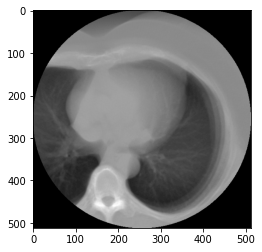

In [4]:
scan1_mean = scan1.mean(0)
_ = plt.imshow(scan1_mean, cmap=plt.cm.gray)

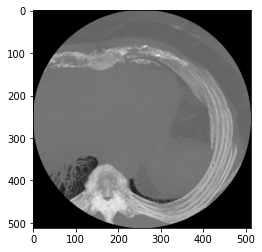

In [5]:
scan1_max = scan1.max(0)
_ = plt.imshow(scan1_max, cmap=plt.cm.gray)

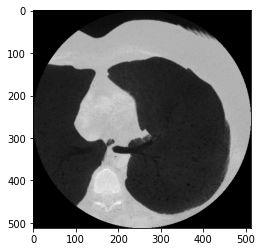

In [6]:
scan1_min = scan1.min(0)
_ = plt.imshow(scan1_min, cmap=plt.cm.gray)

De drie manieren die hierboven staan zorgen allemaal dat de scans naar een 2D afbeelding omgezet worden. Zoals in het Project van Chula geconcludeerd is, blijft er maar op 1 van deze manieren de kalk zichtbaar in de scan. Door het maximale van elke pixel te nemen blijft de kalk, wat een hoge waarde heeft, zichtbaar en is het dus mogelijk om deze te classificeren.

In [3]:
# functie om alle scans te lezen en ze plat te slaan
def read_dicom_slices_dir_max(path: str) -> np.array:
    arr = np.empty((0, 512, 512), int)

    for scans in tqdm.tqdm(glob(f'{path}/*')):
        scan = create_2d_max(read_dicom_slices(scans))
        arr = np.concatenate((arr, [scan]), axis=0)

    return arr

## Onverwachte waardes in de scans

In [5]:
array_min = []
array_max = []

for i in tqdm.tqdm(glob('scans/CAC-Scans-Anonymous/*/*')):
    array_min.append(np.min(dcmread(i).pixel_array))
    array_max.append(np.max(dcmread(i).pixel_array))

100%|██████████| 26531/26531 [01:40<00:00, 262.71it/s]


In [6]:
print('min: ' + str(min(array_min)))
print('max: ' + str(max(array_max)))

min: -2000
max: 4095


Volgens [https://en.wikipedia.org/wiki/Hounsfield_scale#Values_for_different_body_tissues_and_material
](https://en.wikipedia.org/wiki/Hounsfield_scale#Values_for_different_body_tissues_and_material) heeft lucht een waarde van -1.000, dus is een meting van -2.000 waarschijnlijk fout. Een meting van 4095 ligt tussen kalksteen (+2.800) en koper (+14.000)

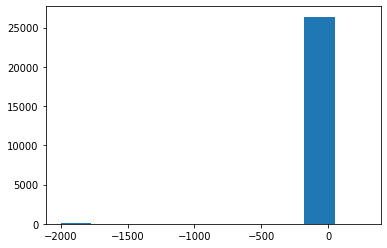

In [7]:
# een histogram met de laagste waarde van elke slice in elke scan
_ = plt.hist(array_min)

Hier is goed te zien dat de scans met -2000 waarschijnlijk een uitzondering zijn. Dit betekent dus dat deze scans gefilterd moeten worden.

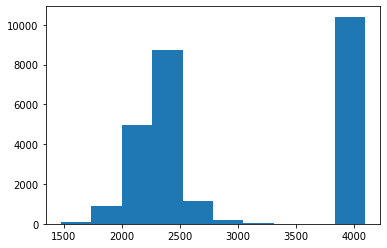

In [8]:
# een histogram met de hoogste waarde van elke slice in elke scan
_ = plt.hist(array_max)

Dit lijkt een redelijk goede verdeling te zijn van de waarden in vergelijking met de histogram van de minimums

In [13]:
l = []
for i in tqdm.tqdm(glob('scans/CAC-Scans-Anonymous/*/*')):
    if np.min(dcmread(i).pixel_array) < -1000:
        l.append(i)
print(l)

100%|██████████| 26531/26531 [00:50<00:00, 523.68it/s]

['scans/CAC-Scans-Anonymous/289/28', 'scans/CAC-Scans-Anonymous/289/40', 'scans/CAC-Scans-Anonymous/289/18', 'scans/CAC-Scans-Anonymous/289/27', 'scans/CAC-Scans-Anonymous/289/2', 'scans/CAC-Scans-Anonymous/289/29', 'scans/CAC-Scans-Anonymous/289/17', 'scans/CAC-Scans-Anonymous/289/38', 'scans/CAC-Scans-Anonymous/289/23', 'scans/CAC-Scans-Anonymous/289/25', 'scans/CAC-Scans-Anonymous/289/12', 'scans/CAC-Scans-Anonymous/289/41', 'scans/CAC-Scans-Anonymous/289/10', 'scans/CAC-Scans-Anonymous/289/5', 'scans/CAC-Scans-Anonymous/289/30', 'scans/CAC-Scans-Anonymous/289/35', 'scans/CAC-Scans-Anonymous/289/6', 'scans/CAC-Scans-Anonymous/289/21', 'scans/CAC-Scans-Anonymous/289/14', 'scans/CAC-Scans-Anonymous/289/45', 'scans/CAC-Scans-Anonymous/289/43', 'scans/CAC-Scans-Anonymous/289/4', 'scans/CAC-Scans-Anonymous/289/16', 'scans/CAC-Scans-Anonymous/289/0', 'scans/CAC-Scans-Anonymous/289/19', 'scans/CAC-Scans-Anonymous/289/47', 'scans/CAC-Scans-Anonymous/289/20', 'scans/CAC-Scans-Anonymous/289/3

De scans met een waarde van -2000 zijn 288, 289 en 290.

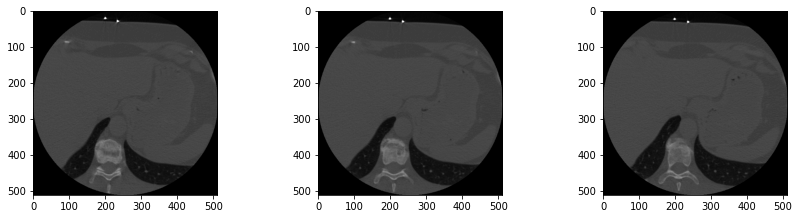

In [9]:
display_dicom_slices(read_dicom_slices('scans/CAC-Scans-Anonymous/28')[:3])

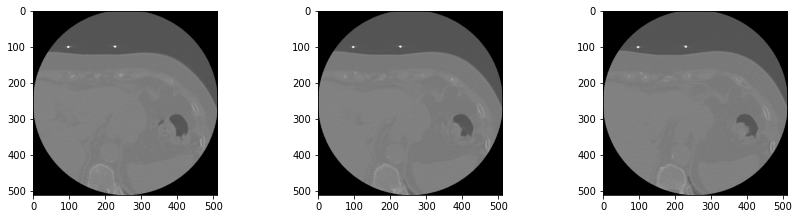

In [10]:
display_dicom_slices(read_dicom_slices('scans/CAC-Scans-Anonymous/288')[:3])

Hierboven is te zien dat bij de eerste scan wel de data goed omgezet is, zodat de lucht aan de bovenkant van de scans te zien is de laagste waarde heeft. Bij de tweede scan zie je dat de lucht aan de bovenkant zeer grijs is, wat betekent dat bij deze scan de lucht niet de laagste waarde heeft, wat wel zou moeten zijn.

Vandaar dat we de scans 288, 289 en 290 in eerste instantie niet zullen gebruiken.

In [2]:
def read_dicom_slices_dir_max(path: str) -> np.array:
    exclude = ['288', '289', '290']
    arr = np.empty((0, 512, 512), int)

    for scans in tqdm.tqdm(glob(f'{path}/*')):
        if scans[26:29] not in exclude:
            scan = create_2d_max(read_dicom_slices(scans))
            arr = np.concatenate((arr, [scan]), axis=0)
    return arr


scans = read_dicom_slices_dir_max('scans/CAC-Scans-Anonymous')

100%|██████████| 505/505 [02:48<00:00,  3.00it/s]


In [3]:
# nu zonder de drie slechte scans
scans.shape

(502, 512, 512)

In [4]:
scans.min()

-91

In [5]:
scans.max()

4095

# Scans normaliseren
De waardes van de scans zijn nu tussen de -91 en 4095. Hoewel een model dit automatisch zou moeten vaststellen, is het een best practice om vooraf alle waardes tussen de 0 en 1 te doen.

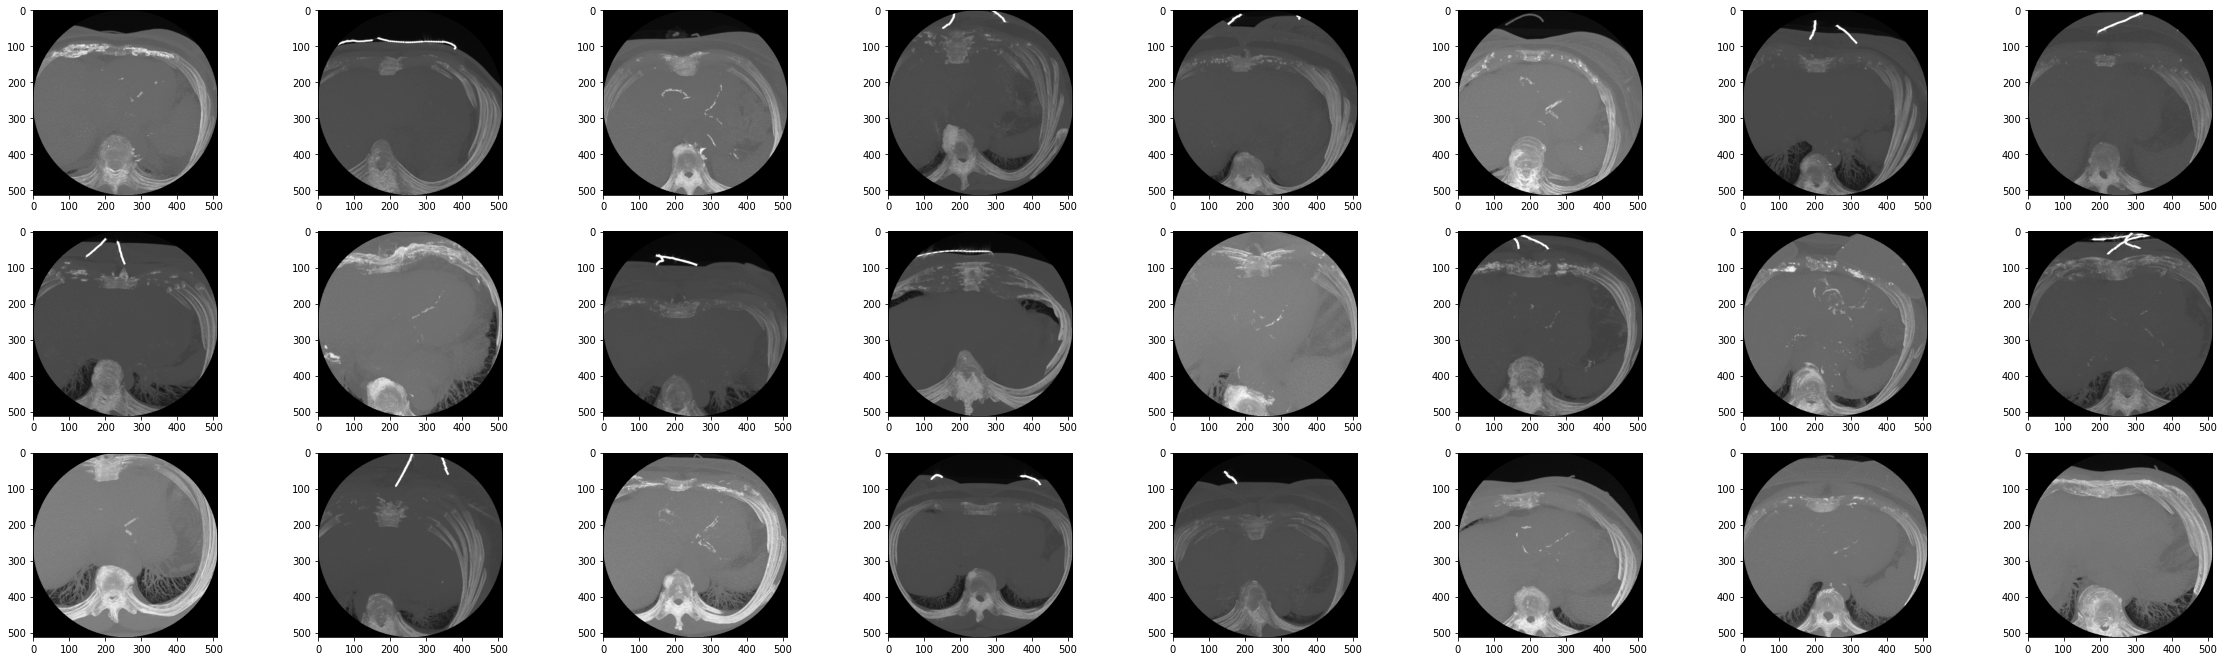

In [5]:
normalised = (scans - np.min(scans)) / (np.max(scans) - np.min(scans))

display_dicom_slices(normalised[:24])

In [29]:
print('min: ' + str(np.min(normalised)))
print('max: ' + str(np.max(normalised)))

min: 0.0
max: 1.0


De waardes liggen nu tussen de 0 en 1. De scans kunnen we nu opslaan zodat deze bij het modelling gebruikt kan worden, zonder dat het nodig is om alle scans opnieuw uit te lezen.

In [20]:
joblib.dump(normalised, 'scans/scans_max_normalised.joblib')

['scans/scans_max_normalised.joblib']

In [ ]:
joblib.dump(np.float16(normalised), 'scans/scans_max_normalised_float16.joblib')

In [40]:
joblib.dump(np.float32(normalised), 'scans/scans_max_normalised_float32.joblib')

['scans/scans_max_normalised_float32.joblib']